In [1]:
import torch
import numpy as np
from torch import Tensor
from numpy import ndarray as array
from helper import to_2d, tensor_size

from typing import Callable, Dict, Tuple, List, NamedTuple

In [2]:
TEST_ALL = False

# Boston data

In [3]:
from sklearn.datasets import load_boston

/Users/seth/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/seth/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [4]:
boston = load_boston()

In [5]:
data = boston.data
target = boston.target
features = boston.feature_names

## SciKit Learn Linear Regression

### Data prep

In [6]:
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
data = s.fit_transform(data)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=80718)

/Users/seth/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Regression

In [8]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
preds = lr.predict(X_test)

/Users/seth/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [9]:
import matplotlib.pyplot as plt

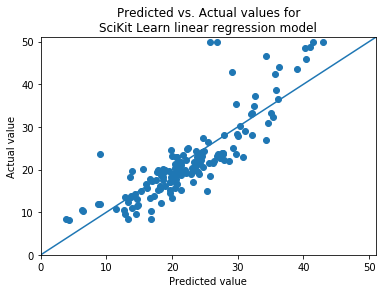

In [10]:
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.title("Predicted vs. Actual values for\nSciKit Learn linear regression model")
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.scatter(preds, y_test)
plt.plot([0, 51], [0, 51])
plt.savefig("images/00_linear_real_pred_vs_actual.png");

### Testing changing feature

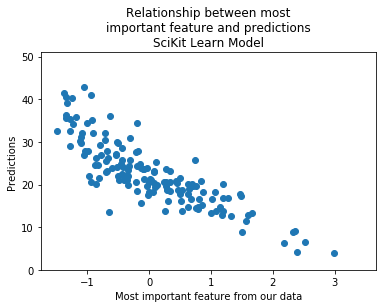

In [11]:
plt.scatter(X_test[:, 12], preds)
plt.ylim([0, 51])
plt.xlabel("Most important feature from our data")
plt.ylabel("Predictions")
plt.title("Relationship between most\nimportant feature and predictions\nSciKit Learn Model")
plt.savefig("images/03_most_important_feature_vs_predictions.png")

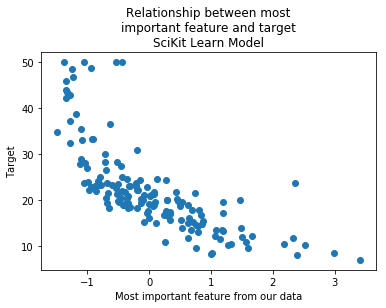

In [12]:
plt.scatter(X_test[:, 12], y_test)
plt.xlabel("Most important feature from our data")
plt.ylabel("Target")
plt.title("Relationship between most\nimportant feature and target\nSciKit Learn Model")
plt.savefig("images/02_most_important_feature_vs_target.png")

Non linear relationship

### Model error

In [13]:
np.round(np.mean(np.abs(preds - y_test)), 4)

3.5666

In [14]:
np.round(np.mean(np.array(np.power(preds - y_test, 2))), 4)

25.4847

In [15]:
import numpy as np
np.round(lr.coef_, 2)

array([-1.01,  0.71,  0.28,  0.71, -2.21,  2.37,  0.72, -2.66,  2.63,
       -1.82, -2.33,  0.86, -4.2 ])

### Manual linear regression

In [16]:
X_train, X_test, y_train, y_test = Tensor(X_train), Tensor(X_test), Tensor(y_train), Tensor(y_test)

In [17]:
def permute_data(X, y):
    perm = torch.randperm(X.shape[0])
    return X[perm], y[perm]

In [18]:
def loss_gradients(forward_info: Dict[str, Tensor], 
                   weights: Dict[str, Tensor]) -> Dict[str, Tensor]:
    
    dLdP = -(forward_info['y'] - forward_info['P'])
    
    dPdN = torch.ones_like(forward_info['N'])

    dPdB = torch.ones_like(weights['B'])
    
    dLdN = dLdP * dPdN
    
    dNdW = forward_info['X'].transpose(0, 1)

    dLdW = torch.mm(dNdW, dLdN)
    
    dLdB = dLdP * dPdB
    
    loss_gradients: Dict[str, Tensor] = {}
    loss_gradients['W'] = dLdW
    loss_gradients['B'] = torch.sum(dLdB)
    
    return loss_gradients

In [19]:
from typing import Iterator
Batch = Tuple[Tensor, Tensor]

def generate_batch(X: Tensor, 
                   y: Tensor,
                   start: int = 0,
                   batch_size: int = 10) -> Batch:
    
    assert (X.dim() == 2) and (y.dim() == 2), \
    "X and Y must be 2 dimensional"

    if start+batch_size > X.shape[0]:
        batch_size = X.shape[0] - start
    
    X_batch, y_batch = X[start:start+batch_size], y[start:start+batch_size]
    
    return X_batch, y_batch

In [20]:
def forward_loss(X: Tensor,
                 y: Tensor,
                 weights: Dict[str, Tensor]) -> Tuple[Dict[str, Tensor], float]:

    N = torch.mm(X, weights['W'])

    P = torch.add(N, weights['B'].item())

    loss = torch.sum(torch.pow(y - P, 2)).item()

    forward_info: Dict[str, Tensor] = {}
    forward_info['X'] = X
    forward_info['N'] = N
    forward_info['P'] = P
    forward_info['y'] = y

    return forward_info, loss

In [21]:
def init_weights(n_in) -> Dict[str, Tensor]:
    
    weights: Dict[str, Tensor] = {}
    W = torch.empty(n_in, 1).uniform_(-1, 1)
    B = torch.empty(1, 1).uniform_(-1, 1)
    
    weights['W'] = W
    weights['B'] = B

    return weights

In [22]:
def train(X: Tensor, 
          y: Tensor, 
          n_iter: int = 1000,
          learning_rate: float = 0.01,
          batch_size: int = 100,
          return_losses: bool = False, 
          return_weights: bool = False, 
          seed: int = 1) -> None:

    if seed:
        torch.manual_seed(seed)
    y = to_2d(y, "col")
    start = 0

    # Initialize weights
    weights = init_weights(X.shape[1])

    # Permute data
    X, y = permute_data(X, y)
    
    if return_losses:
        losses = []

    for i in range(n_iter):

        # Generate batch
        if start >= X.shape[0]:
            X, y = permute_data(X, y)
            start = 0
        
        X_batch, y_batch = generate_batch(X, y, start, batch_size)
        start += batch_size
    
        # Train net using generated batch
        forward_info, loss = forward_loss(X_batch, y_batch, weights)

        if return_losses:
            losses.append(loss)

        loss_grads = loss_gradients(forward_info, weights)
        for key in weights.keys():
            weights[key] -= learning_rate * loss_grads[key]

    if return_weights:
        return losses, weights
    
    return None

In [23]:
train_info = train(X_train, y_train,
                   n_iter = 10000,
                   learning_rate = 0.0002,
                   batch_size=23, 
                   return_losses=True, 
                   return_weights=True, 
                   seed=80718)
losses = train_info[0]
weights = train_info[1]

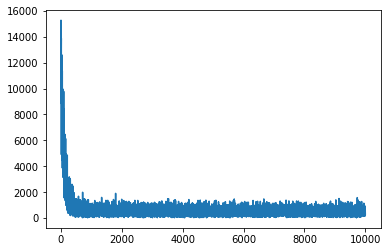

In [24]:
plt.plot(list(range(10000)), losses)

In [25]:
def predict(X: Tensor,
            weights: Dict[str, Tensor]):

    N = torch.mm(X, weights['W'])

    return torch.add(N, weights['B'].item())

In [26]:
preds = predict(X_test, weights)

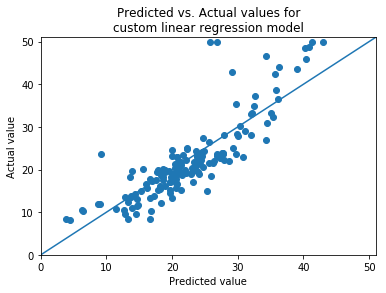

In [27]:
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.title("Predicted vs. Actual values for\ncustom linear regression model")
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.scatter(preds, y_test)
plt.plot([0, 51], [0, 51])
plt.savefig("images/01_linear_custom_pred_vs_actual.png");

### Most important feature plots

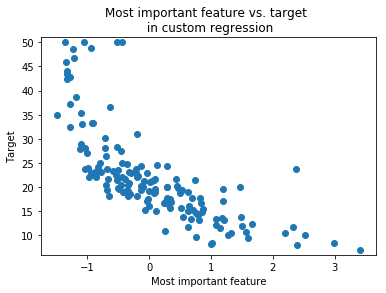

In [28]:
plt.scatter(X_test[:, 12], y_test)
plt.ylim([6, 51])
plt.xlabel("Most important feature")
plt.ylabel("Target")
plt.title("Most important feature vs. target \n in custom regression")
plt.savefig("02_most_important_feature_vs_target.png")

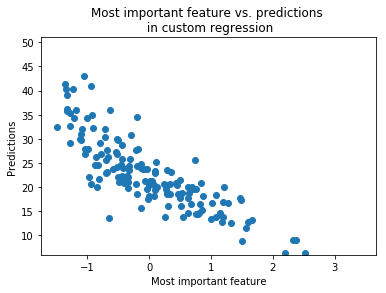

In [29]:
plt.scatter(X_test[:, 12], preds)
plt.ylim([6, 51])
plt.xlabel("Most important feature")
plt.ylabel("Predictions")
plt.title("Most important feature vs. predictions \n in custom regression")
plt.savefig("03_most_important_feature_vs_predictions.png")

In [30]:
y_test

tensor([48.5000, 10.2000, 15.2000,  8.4000, 18.9000, 19.3000, 15.4000, 20.8000,
        29.0000, 23.7000, 33.2000, 19.4000, 17.2000, 42.3000, 15.1000, 23.1000,
        12.1000, 50.0000, 21.6000, 18.5000, 22.9000, 25.0000, 13.9000, 24.2000,
        18.2000, 23.8000, 22.0000, 32.4000, 33.2000, 17.8000, 10.5000, 10.5000,
        23.7000, 21.2000, 21.7000, 43.5000, 38.7000, 27.5000, 23.7000, 28.0000,
        44.0000, 24.4000, 46.7000, 17.6000, 25.0000, 30.1000, 20.5000, 17.1000,
         8.1000, 23.4000, 17.7000, 12.3000, 24.7000, 24.3000, 22.0000, 36.5000,
        22.2000, 22.9000, 16.8000, 20.3000, 21.7000, 37.3000, 11.7000, 34.9000,
        16.7000, 28.2000, 27.9000,  8.5000, 11.5000, 14.9000, 13.1000, 16.1000,
        13.5000,  8.3000, 13.9000, 15.6000, 11.8000, 19.8000, 19.4000, 21.7000,
        13.3000, 23.1000, 18.9000, 18.9000, 21.2000,  7.0000, 50.0000, 17.8000,
        19.0000, 10.2000, 19.8000, 21.4000, 20.2000, 33.1000, 42.8000, 22.3000,
        20.0000, 27.0000, 20.0000, 50.00

In [31]:
torch.mean(torch.abs(preds[:, 0] - y_test))

tensor(3.5674)

In [32]:
torch.mean(torch.pow(preds[:, 0] - y_test, 2))

tensor(25.5106)

### Coefficients

In [33]:
weights['W'][:, 0]

tensor([-1.0014,  0.6908,  0.2472,  0.7149, -2.2061,  2.3760,  0.7110, -2.6672,
         2.5395, -1.7179, -2.3258,  0.8528, -4.1907])

In [34]:
np.round(lr.coef_, 4)

array([-1.0068,  0.7055,  0.279 ,  0.7096, -2.212 ,  2.3732,  0.7165,
       -2.6633,  2.6296, -1.8159, -2.3293,  0.8574, -4.196 ])

In [35]:
weights['B']

tensor([[22.6193]])

In [36]:
np.round(lr.intercept_, 4)

22.6185

### Theoretical relationship between most important feature and target

In [37]:
NUM = 40
a = np.zeros((NUM, 12))
b = np.linspace(-1.5, 3.5, NUM).reshape(NUM, 1)
test_feature = Tensor(np.concatenate([a, b], axis=1))
preds = predict(test_feature, weights)[:, 0]

In [38]:
test_feature[:, -1]

tensor([-1.5000, -1.3718, -1.2436, -1.1154, -0.9872, -0.8590, -0.7308, -0.6026,
        -0.4744, -0.3462, -0.2179, -0.0897,  0.0385,  0.1667,  0.2949,  0.4231,
         0.5513,  0.6795,  0.8077,  0.9359,  1.0641,  1.1923,  1.3205,  1.4487,
         1.5769,  1.7051,  1.8333,  1.9615,  2.0897,  2.2179,  2.3462,  2.4744,
         2.6026,  2.7308,  2.8590,  2.9872,  3.1154,  3.2436,  3.3718,  3.5000])

In [39]:
preds

tensor([28.9053, 28.3681, 27.8308, 27.2935, 26.7563, 26.2190, 25.6817, 25.1444,
        24.6072, 24.0699, 23.5326, 22.9954, 22.4581, 21.9208, 21.3835, 20.8463,
        20.3090, 19.7717, 19.2345, 18.6972, 18.1599, 17.6226, 17.0854, 16.5481,
        16.0108, 15.4736, 14.9363, 14.3990, 13.8617, 13.3245, 12.7872, 12.2499,
        11.7127, 11.1754, 10.6381, 10.1008,  9.5636,  9.0263,  8.4890,  7.9518])

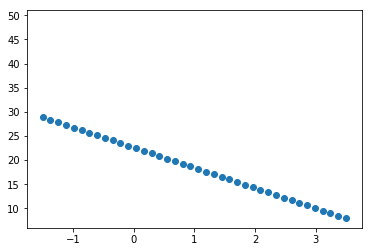

In [40]:
plt.scatter(np.array(test_feature[:, -1]), np.array(preds))
plt.ylim([6, 51])
plt.savefig("04_relationship_most_impt_feat_preds.png")

# Neural network regression

In [41]:
def sigmoid(x: Tensor, 
            deriv: bool=False) -> Tensor:
    if deriv:
        return sigmoid(x) * (1 - sigmoid(x))
    else:
        return 1 / (1 + torch.exp(-1.0 * x))

In [42]:
def init_weights(input_size: int, 
                 hidden_size: int) -> Dict[str, Tensor]:
    
    weights: Dict[str, Tensor] = {}
    weights['W1'] = torch.empty(input_size, hidden_size).uniform_(-1, 1)
    weights['B1'] = torch.empty(1, hidden_size).uniform_(-1, 1)
    weights['W2'] = torch.empty(hidden_size, 1).uniform_(-1, 1)
    weights['B2'] = torch.empty(1, 1).uniform_(-1, 1)
    return weights

In [43]:
def forward_loss(X: Tensor,
                 y: Tensor,
                 weights: Dict[str, Tensor]) -> Tuple[Dict[str, Tensor], float]:

    M1 = torch.mm(X, weights['W1'])

    N1 = torch.add(M1, weights['B1'])

    O1 = sigmoid(N1)
    
    M2 = torch.mm(O1, weights['W2'])

    P = torch.add(M2, weights['B2'].item())    

    loss = torch.sum(torch.pow(y - P, 2)).item()

    forward_info: Dict[str, Tensor] = {}
    forward_info['X'] = X
    forward_info['M1'] = M1
    forward_info['N1'] = N1
    forward_info['O1'] = O1
    forward_info['M2'] = M2
    forward_info['P'] = P
    forward_info['y'] = y

    return forward_info, loss

In [44]:
def loss_gradients(forward_info: Dict[str, Tensor], 
                   weights: Dict[str, Tensor]) -> Dict[str, Tensor]:
    
    dLdP = -(forward_info['y'] - forward_info['P'])
    
    dPdM2 = torch.ones_like(forward_info['M2'])

    dLdM2 = dLdP * dPdM2
  
    dPdB2 = torch.ones_like(weights['B2'])

    dLdB2 = dLdP * dPdB2
    
    dM2dW2 = forward_info['O1'].transpose(0, 1)
    
    dLdW2 = torch.mm(dM2dW2, dLdP)

    dM2dO1 = weights['W2'].transpose(0, 1) 

    dLdO1 = torch.mm(dLdM2, dM2dO1)
    
    dO1dN1 = sigmoid(forward_info['N1'], deriv=True)
    
    dLdN1 = dLdO1 * dO1dN1
    
    dN1dB1 = torch.ones_like(weights['B1'])
    
    dN1dM1 = torch.ones_like(forward_info['M1'])
    
    dLdB1 = dLdN1 * dN1dB1
    
    dLdM1 = dLdN1 * dN1dM1
    
    dM1dW1 = forward_info['X'].transpose(0, 1) 

    dLdW1 = torch.mm(dM1dW1, dLdM1)
    
    def _bias_gradient(grad):
        batch_sum = torch.sum(grad, dim=0)
        size = batch_sum.shape[0]
        return batch_sum.reshape(1, size)
    
    loss_gradients: Dict[str, Tensor] = {}
    loss_gradients['W2'] = dLdW2
    loss_gradients['B2'] = _bias_gradient(dLdB2)
    loss_gradients['W1'] = dLdW1
    loss_gradients['B1'] = _bias_gradient(dLdB1)
    
    return loss_gradients

In [45]:
def predict(X: Tensor, 
            weights: Dict[str, Tensor]):
    
    M1 = torch.mm(X, weights['W1'])

    N1 = torch.add(M1, weights['B1'])

    O1 = sigmoid(N1)
    
    M2 = torch.mm(O1, weights['W2'])

    P = torch.add(M2, weights['B2'].item())    

    return P

In [46]:
def train(X_train: Tensor, y_train: Tensor,
          X_test: Tensor, y_test: Tensor,
          n_iter: int = 1000,
          test_every: int = 1000,
          learning_rate: float = 0.01,
          hidden_size= 13,
          batch_size: int = 100,
          return_losses: bool = False, 
          return_weights: bool = False, 
          return_scores: bool = False,
          seed: int = 1) -> None:

    if seed:
        torch.manual_seed(seed)
    y_train = to_2d(y_train, "col")
    y_test = to_2d(y_test, "col")
    start = 0

    # Initialize weights
    weights = init_weights(X_train.shape[1], 
                           hidden_size=hidden_size)

    # Permute data
    X_train, y_train = permute_data(X_train, y_train)
    

    losses = []
        
    val_scores = []

    for i in range(n_iter):

        # Generate batch
        if start >= X_train.shape[0]:
            X_train, y_train = permute_data(X_train, y_train)
            start = 0
        
        X_batch, y_batch = generate_batch(X_train, y_train, start, batch_size)
        start += batch_size
    
        # Train net using generated batch
        forward_info, loss = forward_loss(X_batch, y_batch, weights)

        if return_losses:
            losses.append(loss)

        loss_grads = loss_gradients(forward_info, weights)
        for key in weights.keys():
            weights[key] -= learning_rate * loss_grads[key]
        
        if return_scores:
            if i % test_every == 0 and i != 0:
                preds = predict(X_test, weights)
                val_scores.append(r2_score(preds, y_test))

    if return_weights:
        return losses, weights, val_scores
    
    return None

In [47]:
if TEST_ALL:
    num_iter = 100000
    test_every = 1000
    train_info = train(X_train, y_train, X_test, y_test,
                       n_iter=num_iter,
                       test_every = test_every,
                       learning_rate = 0.00001,
                       batch_size=23, 
                       return_losses=False, 
                       return_weights=True, 
                       return_scores=False,
                       seed=80718)
    losses = train_info[0]
    weights = train_info[1]
    val_scores = train_info[2]

In [48]:
if TEST_ALL:
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.ylim([-1,1])
    plt.plot(list(range(int(num_iter / test_every - 1))), val_scores); 
    plt.xlabel("Batches (000s)")
    plt.title("Validation Scores")

## Learning rate tuning

In [49]:
def r2_score_lr(learning_rate):
    train_info = train(X_train, y_train, X_test, y_test,
                   n_iter=100000,
                   test_every = 100000,
                   learning_rate = learning_rate,
                   batch_size=23, 
                   return_losses=False, 
                   return_weights=True, 
                   return_scores=False,
                   seed=80718)
    weights = train_info[1]
    preds = predict(X_test, weights)
    return r2_score(y_test, preds)

In [50]:
if TEST_ALL:
    lrs = np.geomspace(1e-2, 1e-6, num=20)

In [51]:
if TEST_ALL:
    r2s = [r2_score_lr(lr) for lr in lrs]

In [52]:
if TEST_ALL:
    plt.semilogx(lrs, r2s)

### Evaluating best model

In [53]:
train_info = train(X_train, y_train, X_test, y_test,
                   n_iter=100000,
                   test_every = 100000,
                   learning_rate = 0.00001,
                   batch_size=23, 
                   return_losses=False, 
                   return_weights=True, 
                   return_scores=False,
                   seed=80718)
weights = train_info[1]

In [54]:
preds = predict(X_test, weights)

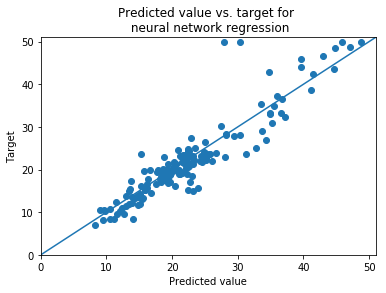

In [55]:
plt.xlabel("Predicted value")
plt.ylabel("Target")
plt.title("Predicted value vs. target for \n neural network regression")
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.scatter(preds, y_test)
plt.plot([0, 51], [0, 51])
plt.savefig("07_neural_network_regression_preds_vs_target.png");

In [56]:
np.mean(np.array(np.abs(preds[:, 0] - y_test)))

2.384995

In [57]:
np.mean(np.array(np.power(preds[:, 0] - y_test, 2)))

13.76389

### Most important feature plots

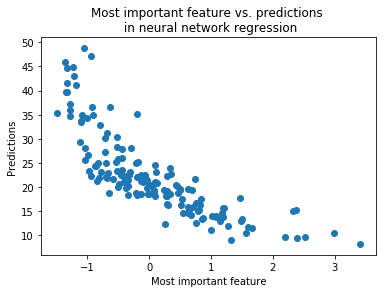

In [58]:
plt.scatter(X_test[:, 12], preds)
plt.ylim([6, 51])
plt.xlabel("Most important feature")
plt.ylabel("Predictions")
plt.title("Most important feature vs. predictions \n in neural network regression")
plt.savefig("08_neural_network_regression_impt_feat_vs_preds.png")

### Theoretical relationship between most important feature and target

In [59]:
NUM = 40
a = np.zeros((NUM, 12))
b = np.linspace(-1.5, 3.5, NUM).reshape(NUM, 1)
test_feature = Tensor(np.concatenate([a, b], axis=1))
preds = predict(test_feature, weights)[:, 0]

In [60]:
test_feature[:, -1]

tensor([-1.5000, -1.3718, -1.2436, -1.1154, -0.9872, -0.8590, -0.7308, -0.6026,
        -0.4744, -0.3462, -0.2179, -0.0897,  0.0385,  0.1667,  0.2949,  0.4231,
         0.5513,  0.6795,  0.8077,  0.9359,  1.0641,  1.1923,  1.3205,  1.4487,
         1.5769,  1.7051,  1.8333,  1.9615,  2.0897,  2.2179,  2.3462,  2.4744,
         2.6026,  2.7308,  2.8590,  2.9872,  3.1154,  3.2436,  3.3718,  3.5000])

In [61]:
preds

tensor([30.0977, 29.4018, 28.7026, 27.9989, 27.2896, 26.5737, 25.8503, 25.1195,
        24.3818, 23.6389, 22.8933, 22.1489, 21.4112, 20.6869, 19.9840, 19.3113,
        18.6776, 18.0910, 17.5580, 17.0829, 16.6675, 16.3108, 16.0095, 15.7583,
        15.5510, 15.3808, 15.2411, 15.1255, 15.0287, 14.9457, 14.8727, 14.8064,
        14.7442, 14.6840, 14.6244, 14.5642, 14.5025, 14.4388, 14.3729, 14.3044])

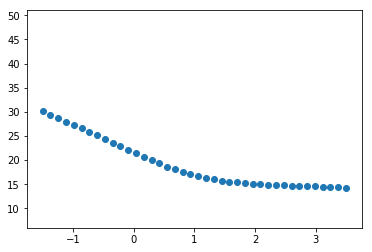

In [62]:
plt.scatter(np.array(test_feature[:, -1]), np.array(preds))
plt.ylim([6, 51])
plt.savefig("09_relationship_most_impt_feat_preds_nn_reg.png")

**NOTE:** I did not include any of the logistic regression stuff in the chapter.

# Logistic regression

### Helpers

In [ ]:
def sigmoid(x: Tensor, 
            deriv: bool=False) -> Tensor:
    if deriv:
        return sigmoid(x) * (1 - sigmoid(x))
    else:
        return 1 / (1 + torch.exp(-1.0 * x))

In [ ]:
def softmax(x: Tensor) -> Tensor:

    assert x.dim() == 2, \
    "Expect Tensor with shape (batch_size, num_classes), instead " + \
    "x has shape {0}".format(x.shape)
    
    def _softmax_row(row: Tensor) -> Tensor:
        
        assert row.dim() == 1, \
        "'row' should indeed be a row, instead it has shape" \
        .format(row.shape)
        
        exp_obs = torch.exp(row)
        sum_exp_obs = exp_obs.sum().item()
        softmax_obs = exp_obs / sum_exp_obs
        
        return softmax_obs

    output_rows = []
    for obs in range(x.shape[0]):
        output_row = to_2d(_softmax_row(x[obs]), "row")
        output_rows.append(output_row)
        
    return torch.cat(output_rows)
    

In [ ]:
softmax(Tensor([[10, 8, 6, 4, 2]]))

## Sklearn logistic regression

In [ ]:
from sklearn.datasets import load_breast_cancer
breast_cancer = load_breast_cancer()
data = breast_cancer.data
target = breast_cancer.target
features = breast_cancer.feature_names

### Data prep

In [ ]:
s = StandardScaler()
data = s.fit_transform(data)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, 
                                                    test_size=0.3, 
                                                    random_state=80718,
                                                    stratify=target)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [ ]:
logr = LogisticRegression(C=10e9)
logr.fit(X_train, y_train)
logr.score(X_test, y_test)

### Hand rolled logistic regression

#### Data preprocessing

In [ ]:
def predictions_to_2d(predictions: Tensor) -> Tensor:
    
    assert predictions.shape[1] == 1, \
    "Expected a column for predictions, got shape: {}".format(predictions.shape)
    
    inverse_predictions = 1 - predictions
    
    return torch.cat([predictions, inverse_predictions], dim=1)

In [ ]:
X_train, X_test, y_train, y_test = Tensor(X_train), Tensor(X_test), Tensor(y_train), Tensor(y_test)

In [ ]:
y_train, y_test = predictions_to_2d(to_2d(y_train, "col")), predictions_to_2d(to_2d(y_test, "col"))

### Modeling functions

In [ ]:
def forward_logistic(X: Tensor,
                     y: Tensor,
                     W: Tensor, 
                     B: Tensor) -> Tensor:
    
    # For the matrix multiplication to work, 
#     assert observations.shape[1] == betas.shape[0], \
#     "Dimensions of betas and feature size do not match"
    
    N = torch.mm(X, W)
    
    O = torch.add(N, B.item())
    
    P = sigmoid(O)

    P = predictions_to_2d(P)
    
    L = cross_entropy(softmax(P), y)
    
    forward_info: Dict[str, Tensor] = {}
    forward_info['X'] = X
    forward_info['W'] = W
    forward_info['B'] = B
    forward_info['N'] = N
    forward_info['O'] = O
    forward_info['P'] = P  
    forward_info['y'] = y 
    
    return forward_info, L.sum().item() / X.shape[0]

In [ ]:
def cross_entropy(predictions: Tensor, 
                  actual: Tensor) -> Tensor:
    
    assert predictions.shape == actual.shape, \
    "Prediction and actual must have same shape"
    
    return -1.0 * actual * torch.log(predictions) - (1.0 - actual) * torch.log(1 - predictions)

In [ ]:
def loss_bce_softmax_deriv(predictions: Tensor, 
                           actual: Tensor) -> Tensor:

    assert predictions.shape == actual.shape, \
    "Prediction and actual must have same shape"

    return to_2d((predictions - actual)[:, 0], "col")

In [ ]:
def loss_gradients_logistic(forward_info: Dict[str, Tensor]) -> Tensor:

#     import pdb; pdb.set_trace()
    dLdP = loss_bce_softmax_deriv(forward_info['P'], 
                                  forward_info['y'])
    
    dPdO = sigmoid(forward_info['O'], deriv=True)
    
    dLdO = dLdP * dPdO
    
    dOdB = torch.ones_like(forward_info['B'])
    
    dLdB = dLdO * dOdB
    
    dOdN = torch.ones_like(forward_info['N'])
    
    dLdN = dLdO * dOdN
    
    dNdW = forward_info['X'].transpose(0, 1)

    dLdW = dNdW.mm(dLdN)
    
    return dLdW, dLdB

In [ ]:
def train(X: Tensor, 
          y: Tensor, 
          n_iter: int = 1000,
          learning_rate: float = 0.01,
          batch_size: int = 100,
          return_losses: bool = False, 
          return_weights: bool = False, 
          seed: int = 1) -> None:

    if seed:
        torch.manual_seed(seed)
    start = 0

    # Initialize weights
    W = torch.empty(X.shape[1], 1).uniform_(-1, 1)
    B = torch.empty(1, 1).uniform_(-1, 1)

    # Permute data
    X, y = permute_data(X, y)
    
    if return_losses:
        losses = []

    for i in range(n_iter):

        if start >= X.shape[0]:
            X, y = permute_data(X, y)
            start = 0
        
        X_batch, y_batch = generate_batch(X, y, start, batch_size)

        start += batch_size
    
        forward_info, loss = forward_logistic(X_batch, y_batch, W, B)

        if return_losses:
            losses.append(loss)

        dLdW, dLdB = loss_gradients_logistic(forward_info)
        W -= learning_rate * dLdW
        B -= learning_rate * torch.sum(dLdB)
    
    if return_weights:
        weights: Dict[str, Tensor] = {}
        weights['W'] = W
        weights['B'] = B
        return losses, weights
    
    return None

In [ ]:
train_info = train(X_train, y_train, 
                   learning_rate = 0.001,
                   batch_size=20, 
                   return_losses=True, 
                   return_weights=True, 
                   seed=80718)
losses = train_info[0]
weights = train_info[1]

In [ ]:
def logistic_predict(X: Tensor, 
                     y: Tensor, 
                     weights: Dict[str, Tensor]):
    
    N = torch.mm(X, weights['W'])
    
    O = torch.add(N, weights['B'].item())
    
    P = sigmoid(O)

    return P >= 0.5

### Prediction

In [ ]:
preds = logistic_predict(X_test, y_test, weights)[:, 0]

In [ ]:
accuracy_score(preds, y_test[:, 0])

In [ ]:
def accuracy_score_lr(learning_rate: float = 0.01, 
                      n_iter: int = 1000) -> float:
    train_info = train(X_train, y_train, 
                       learning_rate=learning_rate,
                       batch_size=20, 
                       n_iter=n_iter,
                       return_losses=True, 
                       return_weights=True, 
                       seed=80718)

    losses = train_info[0]
    weights = train_info[1]

    preds = logistic_predict(X_test, y_test, weights)[:, 0]
    
    return accuracy_score(preds, y_test[:, 0])

In [ ]:
iters = np.geomspace(10, 10000, 50)

In [ ]:
accs = [accuracy_score_lr(0.01, int(it)) for it in iters]

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# plt.xlim(iters[-1], lrs[0])
plt.semilogx(iters, accs);

In [ ]:
lrs = np.geomspace(0.1, 0.00001, 50)

In [ ]:
accs_lr = [accuracy_score_lr(float(lr), 1000) for lr in lrs]

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# plt.xlim(iters[-1], lrs[0])
plt.semilogx(lrs, accs_lr);

### Analyzing best model

In [ ]:
train_info = train(X_train, y_train, 
                   learning_rate=0.01,
                   batch_size=20, 
                   n_iter=1000,
                   return_losses=True, 
                   return_weights=True, 
                   seed=80718)

losses = train_info[0]
weights = train_info[1]

preds = logistic_predict(X_test, y_test, weights)[:, 0]

In [ ]:
logr.coef_

In [ ]:
weights['W']

In [ ]:
def logistic_baseline_random(X: Tensor, 
                             y: Tensor,
                             seed: int = 1):
    
    torch.manual_seed(seed)
    # Initialize weights
    W = torch.empty(X.shape[1], 1).uniform_(-1, 1)
    B = torch.empty(1, 1).uniform_(-1, 1)
    
    weights: Dict[str, Tensor] = {}
    weights['W'] = W
    weights['B'] = B

    preds = logistic_predict(X, y, weights)[:, 0]
    
    return accuracy_score(preds, y[:, 0])

In [ ]:
target_2d = predictions_to_2d(to_2d(Tensor(target), "col"))

In [ ]:
logistic_baseline_random(Tensor(data), target_2d, 
                         seed=80718)

In [ ]:
a = sum(target == 1) / len(target)
a ** 2 + (1 - a) ** 2